In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy.optimize import fsolve
import datetime
import integrLie as lie

## Analysis of the log-norm on $S^2$
Suppose that a vector field is expressed in local coordinates as $Y= Y^1\partial_1 + Y^2\partial_2$ 
where $\partial_1 = \partial_\phi,\ \partial_2 = \partial_\theta$. 
Its Jacobian matrix is denoted $B=B(Y^1,Y^2)$. We have found that the contractivity of such a problem amounts to studying when the quantity

$$\mu_g(L(Y))=  \lambda_{\max}\left[ \tfrac12 (GL(Y)G^{-1}+L(Y)^T)\right]$$

is non-positive. Here $G$ is the metric tensor with respect to the coordinates and $L(Y)$ is the
matrix of the linear map $X\mapsto \nabla_X Y$ expressed in the same coordinates. In spherical coordinates it is well-known that

$$
    G =\left[ \begin{array}{cc} 1 & 0 \\ 0 & \cos^2\phi \end{array} \right]
$$
One can calculate the Christoffel symbols

$$
\Gamma^1_{ij} = \left[\begin{array}{cc} 0 & 0\\ 0 & \sin\phi\cos\phi\end{array}\right],\qquad
\Gamma^2_{ij} = \left[\begin{array}{cc} 0 & -\tan\phi\\ -\tan\phi & 0\end{array}\right]
$$

The connection therefore takes the following expression in spherical coordinates

$$
\nabla_X Y = \nabla_X (Y^i\partial_i) = X(Y^i)\partial_i + X^j Y^i\nabla_{\partial_j}\partial_i
$$

The first term is simply $X^j\partial_j(Y^i)\partial_i = (B X)^i$. In the second we use the Christoffel symbols
$\nabla_{\partial_j}\partial_i = \Gamma^m_{ij}\partial_m$ to get $X^j Y^i\nabla_{\partial_j}\partial_i=(AX)^m$ where $A^m_j = \Gamma^m_{ij} Y^i$. We can conclude that in the above expression $L=L(Y)=A+B$.

$$
    \left[\begin{array}{cc} b_{11} & \tfrac12(\frac{b_{12}}{\cos^2\phi}+b_{21})\\
 \tfrac12(\cos^2\phi\; b_{21} + b_{12}) & b_{22}  -Y_1\tan\phi \end{array}\right]
$$


In [2]:
def spherical2cart(s):
    return np.array([np.cos(s[0])*np.cos(s[1]), np.cos(s[0])*np.sin(s[1]),np.sin(s[0])])


def cart2spherical(y):
    try:
        np.linalg.norm(y) < 1 + 1e-6 or np.linalg.norm(y) > 1 - 1e-6
    except:
        raise Exception('Not on the sphere')
    return np.array([np.arcsin(y[2]), np.arctan2(y[1],y[0])])

def rDistance(y,z):
    return 2*np.arcsin(np.linalg.norm(y-z,2)/2)

def ProjS2(p,q,t):
    return ((1-t)*p+t*q)/np.linalg.norm((1-t)*p+t*q)

Let's consider the following energy function on a sphere, $q\in S^2$
$$E(q)=\frac{1}{2}q^\top Dq$$
We consider the gradient and its projection on the tangent space $TS^2$
$$\text{grad}E(q)=\left(\mathbb{I}-qq^\top\right)Dq.$$

The equations leading the problem are
$$
\dot{q}=-\text{grad}E(q)=-Dq+2E(q)q
$$

where we choose
$$D=\begin{pmatrix}
a &0 &0\\
0 &a &0\\
0 &0 &c
\end{pmatrix}$$
ending up with the problem

$$\dot{q}=\begin{pmatrix}
2E(q)-a &0 &0\\
0 &2E(q)-a &0\\
0 &0 &2E(q)-c
\end{pmatrix}\cdot q$$


In order to write the problem as $\dot{y}=A(y)\cdot y$, with $A(y)$ skew symmetric, we manipulate the equations.
Let $f$ be the gradient of the energy. Then we have
$$\dot{y} = -(fy^\top-yf^\top)\cdot y$$
It is easy to verify that $(fy^\top-yf^\top)$ is skew symmetric by construction and that the right hand side is equivalent to the negative gradient.

In [3]:
def symmJac(A,B,y):
    return np.array([[B[0,0], 0.5*(B[0,1]/(np.cos(y[0])**2)+B[1,0])],[0.5*(np.cos(y[0])**2*B[1,0]+B[0,1]), B[1,1]-A[0]*np.tan(y[0])]])

In [4]:
def negSkwMatrix(x,D):
    x = x.reshape(3,1)
    f = ((np.eye(3)-x*np.transpose(x))@D)@x
    return f*np.transpose(x)-x*np.transpose(f)

def energy(x,D):
    return 0.5*np.transpose(x)@D@x

def LieEuler(x0,x,D,dt):
    x0 = x0.reshape(3,1)
    return expm(dt*(-negSkwMatrix(x,D)))@x0.reshape(3,)

my_fun = lambda x, x0, D, dt : - x + LieEuler(x0, x, D, dt)

In [5]:
# initialization
# I1 = np.random.rand(1)
# I3 = np.random.rand(1)
I1 = 0.5
I3 = 15.0
if I1 > I3:
    tmp = np.copy(I3)
    I3 = np.copy(I1)
    I1 = np.copy(tmp)
I2 = np.copy(I1)
diag = np.array([1/I1, 1/I2, 1/I3]).reshape(3,)
Inertia = np.diag(diag)

print(Inertia)

h = np.arange(0.10,10.0,0.1)
N = np.size(h)
nTime = 1000
time = np.linspace(h[0],h[-1],nTime)
dt = time[1]-time[0]
maxIt = 30
tol = 1e-12

print(dt)

phi0 = np.zeros((2,))
theta0 = np.zeros((2,))
phi0[0]=-np.pi/2+(np.pi/4)*np.random.rand()
# phi0[0]=-np.pi/4+(np.pi/4)*np.random.rand()
theta0[0]=2*np.pi*np.random.rand()
phi0[1]=phi0[0]
theta0[1]=theta0[0]+0.1*theta0[0]

q = np.zeros((3,2,3,N+1))
RD = np.zeros((3,N+1))
q[0,0,:,0] = spherical2cart([phi0[0],theta0[0]])
q[0,1,:,0] = spherical2cart([phi0[1],theta0[1]])
q[1,0,:,0] = np.copy(q[0,0,:,0])
q[1,1,:,0] = np.copy(q[0,1,:,0])
q[2,0,:,0] = np.copy(q[0,0,:,0])
q[2,1,:,0] = np.copy(q[0,1,:,0])
RD[0,0] = rDistance(q[0,0,:,0],q[0,1,:,0])
RD[1,0] = rDistance(q[0,0,:,0],q[0,1,:,0])
RD[2,0] = rDistance(q[0,0,:,0],q[0,1,:,0])

print(phi0)
print(theta0)
print(RD[0,0])
print(RD[1,0])
print(RD[2,0])

[[2.         0.         0.        ]
 [0.         2.         0.        ]
 [0.         0.         0.06666667]]
0.009809809809809805
[-1.53729772 -1.53729772]
[0.28215979 0.31037577]
0.0009449878345953773
0.0009449878345953773
0.0009449878345953773


In [9]:
now = datetime.datetime.now().strftime('%Y%m%dT%H%M%S')

tmpExact = np.zeros((2,3,nTime+1))
tmpExact[0,:,0] = np.copy(q[0,0,:,0])
tmpExact[1,:,0] = np.copy(q[0,1,:,0])
# for cnt in range(nTime):
#     for j in range(2):
#         tmpExact[j,:,cnt+1] = fsolve(my_fun, tmpExact[j,:,cnt], args=(tmpExact[j,:,cnt], Inertia, dt))

for k in range(N):
    for j in range(2):
        # q[1,j,:,k+1] = LieEuler(q[1,j,:,0],q[1,j,:,0],Inertia,h[k])
        # q[2,j,:,k+1] = fsolve(my_fun, q[2,j,:,k], args=(q[2,j,:,0], Inertia, h[k]))
        q[2,j,:,k+1] = lie.implieeul(lambda x: lie.skwinv(-negSkwMatrix(x, Inertia)), q[2,j,:,k], q[2,j,:,0], h[k])
        # q[1,j,:,k+1] = lie.implliemidp(lambda x: lie.skwinv(-negSkwMatrix(x, Inertia)), q[1,j,:,k], q[1,j,:,0], h[k])
        q[1,j,:,k+1] = lie.impllietrap(lambda x: lie.skwinv(-negSkwMatrix(x, Inertia)), q[1,j,:,k], q[1,j,:,0], h[k])
        q[0,j,:,k+1] = tmpExact[j,:,(k+1)*(nTime//(N+1))]
    RD[0,k+1] = rDistance(q[0,0,:,k+1],q[0,1,:,k+1])
    RD[1,k+1] = rDistance(q[1,0,:,k+1],q[1,1,:,k+1])
    RD[2,k+1] = rDistance(q[2,0,:,k+1],q[2,1,:,k+1])

# np.save('../out/'+now+'_S2_sols',q)
# np.save('../out/'+now+'_S2_dist',RD)
# np.save('../out/'+now+'_S2_matD',Inertia)

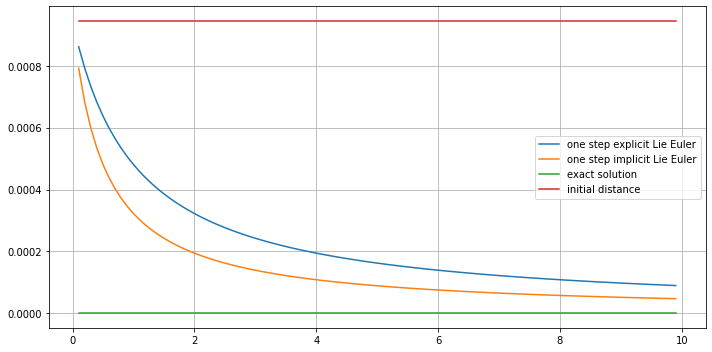

In [11]:
fig1 = plt.figure()
plt.plot(h, RD[1,1:], label='one step explicit Lie Euler')
plt.plot(h, RD[2,1:], label='one step implicit Lie Euler')
plt.plot(h, RD[0,1:], label='exact solution')
plt.plot(h, RD[0,0]*np.ones((N, )), label='initial distance')
plt.legend()
plt.grid()

plt.show()

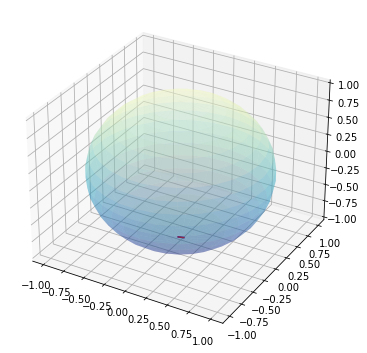

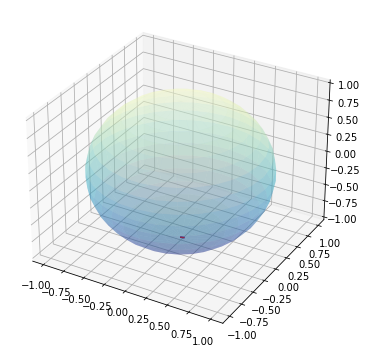

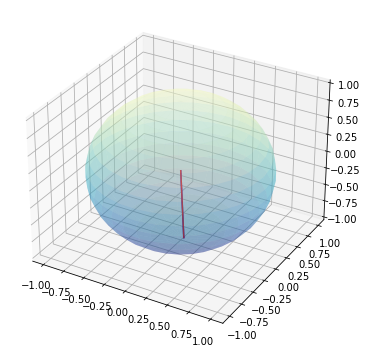

In [8]:
import numpy
plt.rcParams["figure.figsize"] = [10.00, 5.00]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
u, v = numpy.mgrid[0: 2 * np.pi: 30j, 0: np.pi: 20j]
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)
ax.plot_surface(x, y, z, cmap = plt.cm.YlGnBu_r,alpha=0.3)

ax.plot(q[1,0,0,:],q[1,0,1,:],q[1,0,2,:],'blue')
ax.plot(q[1,1,0,:],q[1,1,1,:],q[1,1,2,:],'red')


fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
u, v = numpy.mgrid[0: 2 * np.pi: 30j, 0: np.pi: 20j]
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)
ax.plot_surface(x, y, z, cmap = plt.cm.YlGnBu_r,alpha=0.3)

ax.plot(q[2,0,0,:],q[2,0,1,:],q[2,0,2,:],'blue')
ax.plot(q[2,1,0,:],q[2,1,1,:],q[2,1,2,:],'red')

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
u, v = numpy.mgrid[0: 2 * np.pi: 30j, 0: np.pi: 20j]
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)
ax.plot_surface(x, y, z, cmap = plt.cm.YlGnBu_r,alpha=0.3)

ax.plot(q[0,0,0,:],q[0,0,1,:],q[0,0,2,:],'blue')
ax.plot(q[0,1,0,:],q[0,1,1,:],q[0,1,2,:],'red')

plt.show()